# **Clustering KMeans Sentinel2**

To run an unsupervised classification on satellite data using Python you need GDAL, Numpy and Sklearn. If you wish to see the data you will also need Matplotlib. Assuming you have the libraries installed, import them at the start.

Lets start with a single band image

In [3]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 38.5 MB/s eta 0:00:00


In [4]:
import rasterio
import numpy as np

# Open the .tiff file
with rasterio.open('Sentinel-2_L2A_Galapagos.tiff') as src:
    band = src.read(2)  # Read the second band
    print(band.shape)

X = band.reshape((-1, 1))
print(X.shape)

# Perform clustering
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

X_cluster = k_means.labels_.reshape(band.shape)
print(X_cluster.shape)


(1992, 2500)
(4980000, 1)
(1992, 2500)


Plot the classified image

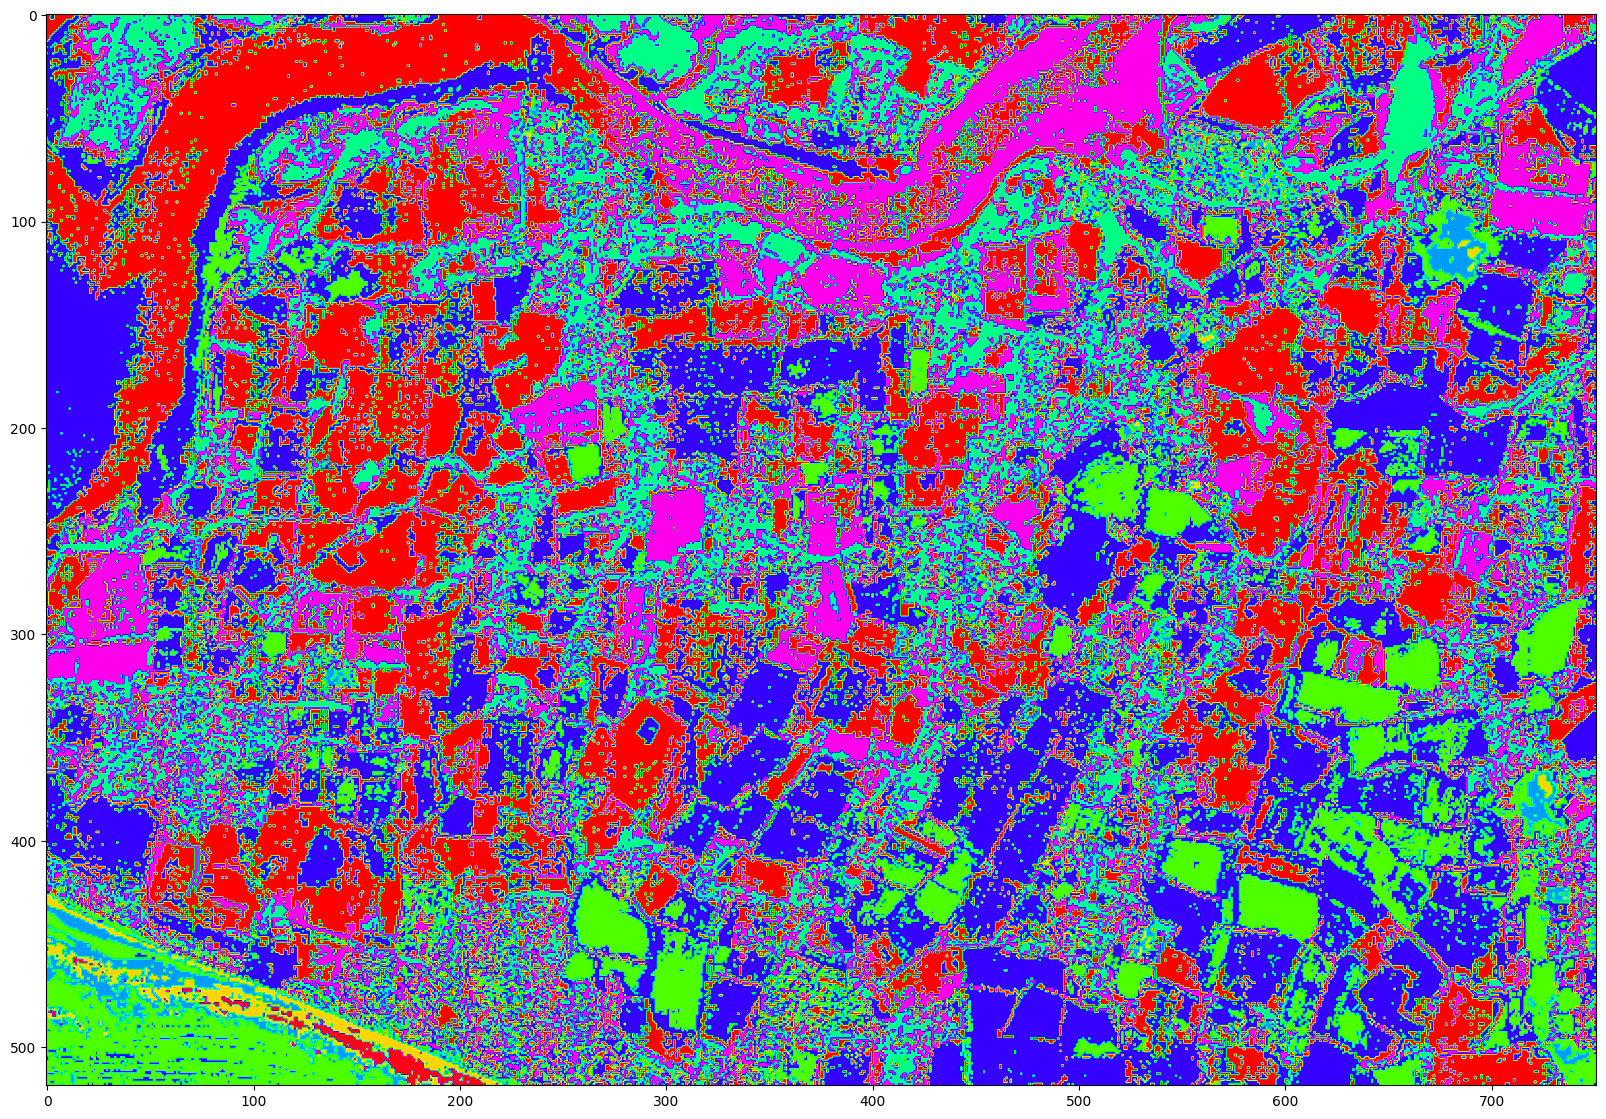

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

What about using all 13 bands of Sentinel 2?

In [5]:
import numpy as np
from osgeo import gdal, gdal_array

# Tell GDAL to throw Python exceptions and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Open the .tiff file
img_ds = gdal.Open('Sentinel-2_L2A_Galapagos.tiff', gdal.GA_ReadOnly)
if img_ds is None:
    raise FileNotFoundError("The specified file could not be opened.")

# Prepare an empty array to store the image data for all bands
img = np.zeros(
    (img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
    dtype=gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType),
)

# Read each band into the corresponding slice of the array
for b in range(img_ds.RasterCount):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

print("Shape of the image with all bands:", img.shape)  # (height, width, num_bands)

# Reshape for processing
new_shape = (img.shape[0] * img.shape[1], img.shape[2])  # (num_pixels, num_bands)
X = img.reshape(new_shape)

print("Shape of reshaped data for all bands:", X.shape)  # (num_pixels, num_bands)


Shape of the image with all bands: (1992, 2500, 4)
Shape of reshaped data for all bands: (4980000, 4)


Now fit it

In [6]:
k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)

X_cluster = k_means.labels_


X_cluster = X_cluster.reshape(img[:, :, 0].shape)

And plot

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
print (X_cluster.shape)

plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

Changing the classification is straight forward. In this example choose MiniBatchKMeans

In [ ]:
MB_KMeans = cluster.MiniBatchKMeans(n_clusters=8)
MB_KMeans.fit(X)

X_cluster = MB_KMeans.labels_


X_cluster = X_cluster.reshape(img[:, :, 0].shape)

Plot the result

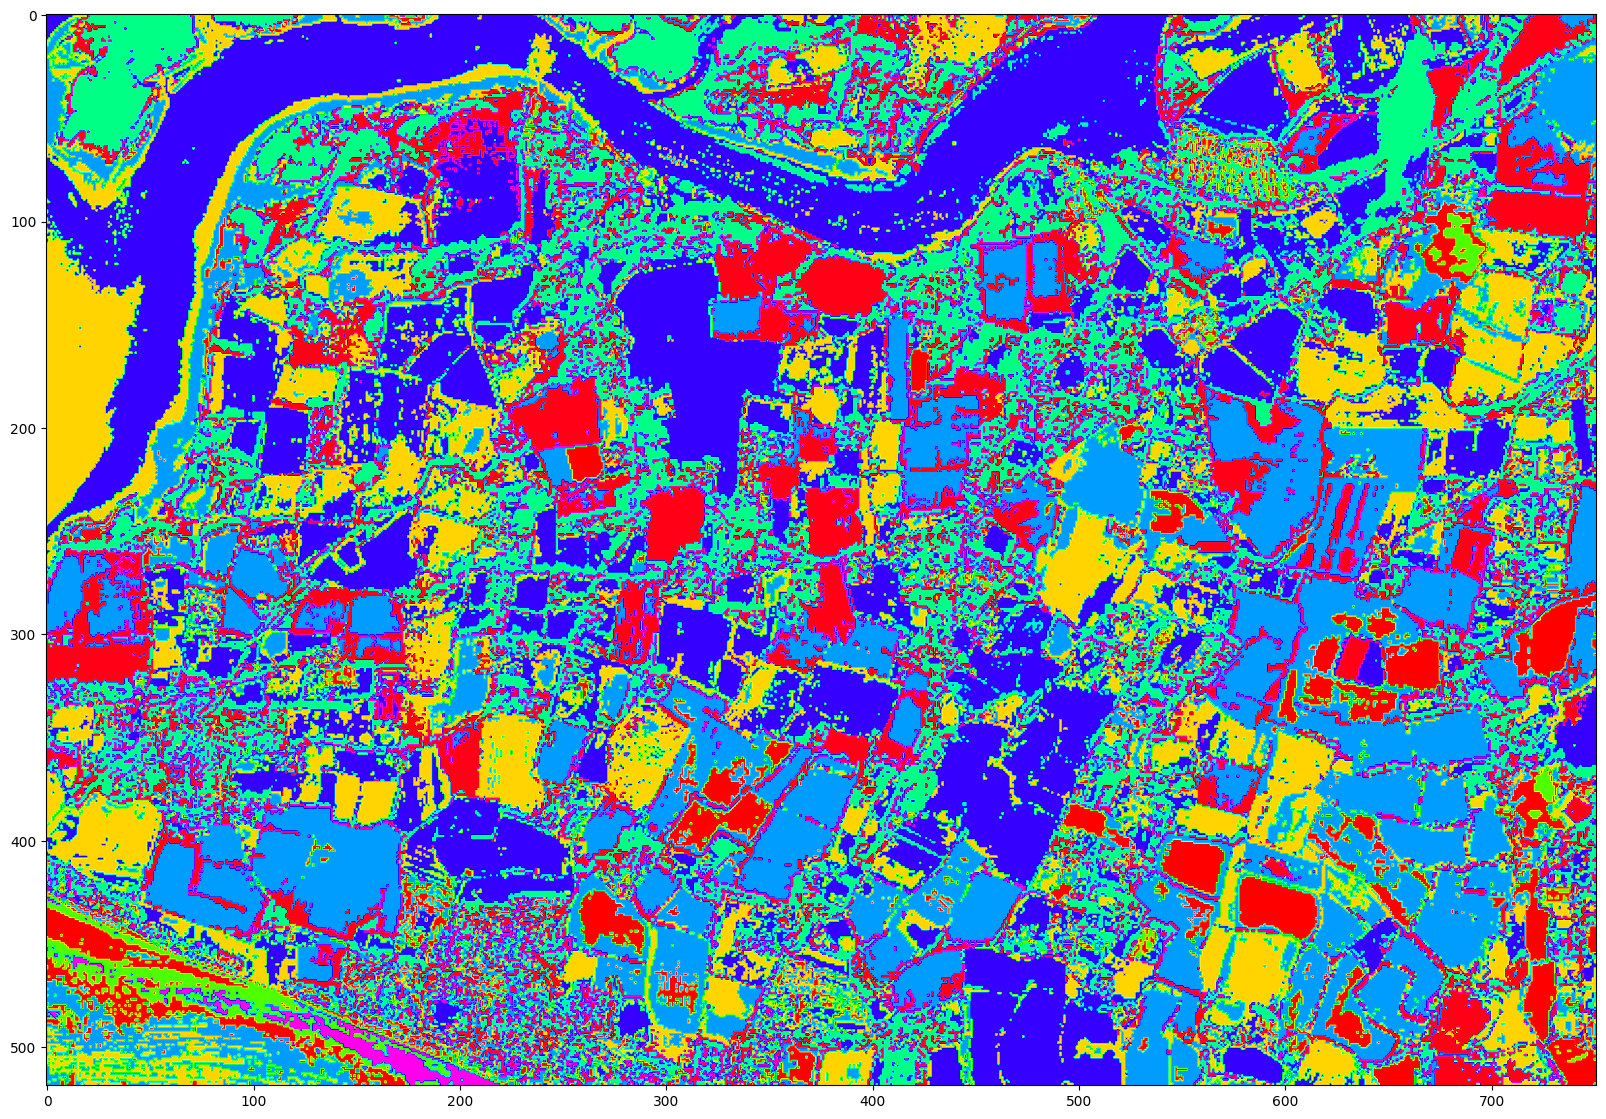

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")

plt.show()

Final save the result to a bew geotiff

In [ ]:
from osgeo import gdal, gdal_array
## write out to tiff
### single band raster.

ds = gdal.Open("South_coast.tif")
band = ds.GetRasterBand(2)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

format = "GTiff"
driver = gdal.GetDriverByName(format)


outDataRaster = driver.Create("k_means.gtif", rows, cols, 1, gdal.GDT_Byte)
outDataRaster.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(ds.GetProjection())##sets same projection as input


outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)